# A bit of introspection

In this script, we explore what's happening inside a CNN classifier.

In [4]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

# Define the data repository
data_dir = 'data/'

## Dataset and model

We use the MNIST dataset (we only need the training set here, and we use a larger subset of the data). We also provide a pretrained CNN classifier (same architecture as in the previous lab).

In [5]:
# Load the MNIST dataset
train_data = datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

# Take a subset
len_dataset = 2000
train_data = Subset(train_data, torch.arange(len_dataset))

# Create dataloader
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
len_dataset = len(train_dataloader) * batch_size

In [8]:
# Model definition
class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif_bnorm, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels1),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels2),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(7*7*num_channels2, num_classes)
    
    def forward(self, x):
        
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out

# Instanciate the model
num_channels1 = 16
num_channels2 = 32
model = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)

# Load the pretrained model's parameters
model.load_state_dict(torch.load('model_cnn_classif_introspection.pt'))

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

Total number of parameters:  29034


## Vizualizing feature maps

Let's visualize the feature maps to have a rough understanding of what has been computed through the CNN layers.

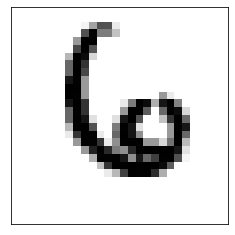

In [9]:
# Retrieve a batch of images
image_batch_example = next(iter(train_dataloader))[0]

# Retrieve the first image in the batch
image_example = image_batch_example[0].squeeze()

# Plot the image
plt.figure()
plt.imshow(image_example, cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

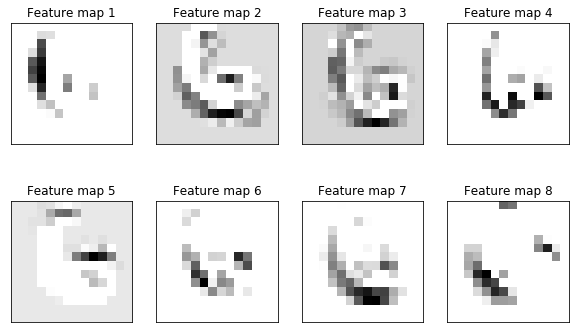

In [10]:
# Compute the output of the first convolution layer
model.eval()
out_conv1 = model.cnn_layer1(image_batch_example)

# Get the feature maps corresponding to the first image in the batch
features_maps1 = out_conv1.detach()[0]

# Plot the first 8 feature maps
plt.figure(figsize = (10, 6))
for ic in range(8):
    plt.subplot(2, 4, ic+1)
    plt.imshow(features_maps1[ic,:], cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Feature map ' + str(ic+1))
plt.show()

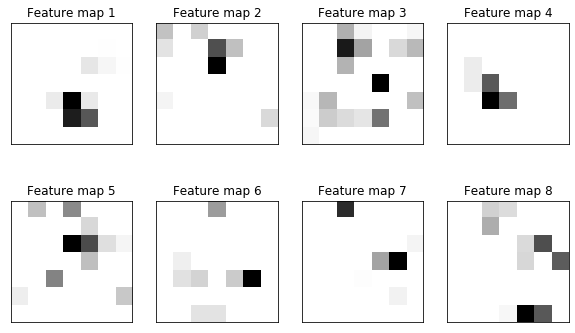

In [11]:
# TO DO:
# - compute the output of the second convolution layer from out_conv2
# - get the feature maps corresponding to the first image in the batch
# - plot the first 8 feature maps

out_conv2 = model.cnn_layer2(out_conv1)
features_maps2 = out_conv2.detach()[0]

plt.figure(figsize = (10, 6))
for ic in range(8):
    plt.subplot(2, 4, ic+1)
    plt.imshow(features_maps2[ic,:], cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Feature map ' + str(ic+1))
plt.show()


<span style="color:red">**Q1**</span> Put the plot above in your report. What can you say about it compared to the first layer feature maps?

## t-SNE

Even though the lack of interpretability is one major drawback of (deep) neural networks, we can still partly analyze its behavior. In particular, for classification tasks, we expect the network to learn features maps that allow to distinguish more and more between classes as we go deep inside the network: that's precisely why it's trained.

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is an algorithm that allows to vizualize high-dimensional data (either raw images or features maps). It projects the data into a low-dimensional space (usually 2D or 3D), and the resulting projected data is called *t-SNE embeddings*. These embeddings can be easily plotted in 2D or 3D, and they allow to see how data samples from different classes are distributed.

In mathematical terms, consider we have a set of data points $\mathbf{x}_i \in \mathbb{R}^N$: for instance, $\mathbf{x}_i$ can be a (vectorized) image or a set of (vectorized) feature maps inside a network. It's difficult to visualize these data points directly because $N$ is usually very large. Therefore, the goal of the t-SNE algorithm is to calculate low-dimension embeddings $\mathbf{y}_i \in \mathbb{R}^2$ (or $\mathbb{R}^3$), such that if two points $\mathbf{x}_i$ and $\mathbf{x}_j$ are close/similar, then the corresponding embeddings $\mathbf{y}_i$ and $\mathbf{y}_j$ will be close/similar as well. As a result, we can easily plot the embeddings $\mathbf{y}_i$ in 2D (or 3D), and visualize the similar data points, see if there are some noticeable clusters, etc.

In [12]:
# First, let us collect all the vectorized input images into one tensor (same for labels)
# Then, we convert these back to numpy

images_tot = torch.empty((len_dataset, 1*28*28), dtype=torch.float)
labels_im_tot = torch.empty(len_dataset, dtype=torch.float)

model.eval()
with torch.no_grad():
    for ib, (images, labels) in enumerate(train_dataloader):
        indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
        labels_im_tot[indices_b] = labels.float()
        in_im_vec = images.reshape(batch_size, -1)
        images_tot[indices_b, :] = in_im_vec

images_tot = images_tot.numpy()
labels_im_tot = labels_im_tot.numpy()
print('Size of vectorized input images:', images_tot.shape)
print('Size of the tensor storing labels:', labels_im_tot.shape)

Size of vectorized input images: (2000, 784)
Size of the tensor storing labels: (2000,)


In [13]:
# Compute t-SNE embeddings from the input images
images_TSNE = TSNE(n_components=2, init='pca').fit_transform(images_tot)
print('Size TSNE embeddings (input images):', images_TSNE.shape)

Size TSNE embeddings (input images): (2000, 2)


In [14]:
# We provide here a function for displaying the t-SNE embeddings 
def plot_tsne_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (6,6))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

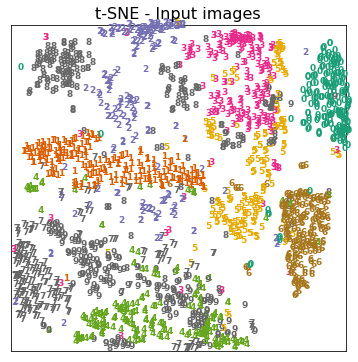

In [15]:
# Apply this function to the input images after TSNE
plot_tsne_embeddings(images_TSNE, labels_im_tot, 'Input images')

We can see above that the data samples corresponding to input images are roughly organized into categories (or *clusters*). However, there is some overlap between classes, which is why a basic classifier operating on raw images might not work very well. The CNN classifier learns to transform this data (by computing feature maps) in a way that the resulting data will form more distinct clusters.

In [16]:
# TO DO:
# - compute the feature maps(outputs of layer 2 of the CNN) over the dataset
# - vectorize these and store them into a single tensor
# - also store the labels
# - convert the tensors back to numpy
# - display their sizes

feature_maps_tot = torch.empty((len_dataset, 32*7*7), dtype=torch.float)
labels_fm_tot = torch.empty(len_dataset, dtype=torch.float)

model.eval()
with torch.no_grad():
    for ib, (images, labels) in enumerate(train_dataloader):
        indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
        labels_fm_tot[indices_b] = labels.float()
        out_conv1 = model.cnn_layer1(images)
        out_conv2 = model.cnn_layer2(out_conv1)
        feats_vec = out_conv2.reshape(batch_size, -1)
        feature_maps_tot[indices_b, :] = feats_vec

feature_maps_tot = feature_maps_tot.numpy()
labels_fm_tot = labels_fm_tot.numpy()
print('Size of vectorized feature maps:', feature_maps_tot.shape)
print('Size of the tensor storing labels:', labels_fm_tot.shape)


Size of vectorized feature maps: (2000, 1568)
Size of the tensor storing labels: (2000,)


In [17]:
# TO DO: Compute t-SNE embeddings from the feature maps
feature_maps_TSNE = TSNE(n_components=2, init='pca').fit_transform(feature_maps_tot)
print('Size TSNE embeddings (feature maps):', feature_maps_TSNE.shape)

Size TSNE embeddings (feature maps): (2000, 2)


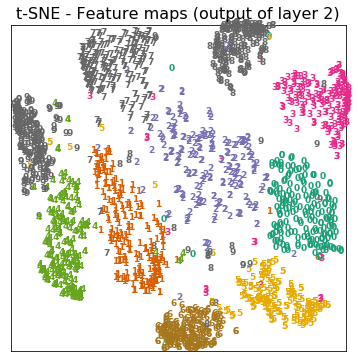

In [18]:
# TO DO: plot the corresponding t-SNE embeddings (use the 'plot_tsne_embeddings' function)
plot_tsne_embeddings(feature_maps_TSNE, labels_fm_tot, 'Feature maps (output of layer 2)')

<span style="color:red">**Q2**</span> Put the plot above in your report. What do you observe compared to the t-SNE embeddings computed from the input images?